#### TF.SnoqualmieData.SupportingObs
Prepares Snoqualmie data to be used in evaluating a model:

- snow pit obs
- surface temperature (broken down by snow surface and ground surface temperature)
- snow height
- SWE (derived)
- melt outflow
- Observed fluxes: 4 stream rad, turb., ground

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

/Users/karllapo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirData = dir_pre+'GroundObs/Snoqualmie/Raw/SNQ_Data/'                # Unprocessed Snoqualmie data
dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'           # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirOut = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'    # Processed data directory

In [4]:
#### Supporting information:
# Surface temperature
# Snow height
def parse(y, mo, dy, hr, mn):
    s = '00'
    date_str = y+':'+mo+':'+dy+'_'+hr+':'+mn+':'+s
    dt = datetime.strptime(date_str,"%Y:%m:%d_%H:%M:%S")
    return dt

os.chdir(dir_data+'Quality_Controled')
datafile = 'SNQ_QC_30min_2013_2015.TSURF.csv'
support = pd.read_csv(datafile,sep=',',header=0,na_values=-9999,\
                   parse_dates={'Datetime' : [0,1,2,3,4]},date_parser=parse,index_col='Datetime')
support = support.rename({'Datetime': 'time'})
support = support.reindex(ds.time.values,fill_value=np.nan)
ds['Tsurf'] = (('time'),np.nanmean(support.Tsrf_1,support.Tsrf_2))


In [7]:
print(ds)
os.chdir(dir_out)
ds.to_netcdf('SnoqualmieObs.wy2013.wy2015.nc')

<xray.Dataset>
Dimensions:  (time: 45741)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01 2012-10-01T00:30:00 ...
Data variables:
    precip   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SWdwn    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    LWdwn    (time) float64 286.9 286.9 286.5 286.5 286.5 286.5 286.5 286.5 ...
    Tair     (time) float64 279.0 279.0 279.0 279.2 279.4 279.4 279.1 278.9 ...
    WIND     (time) float64 0.068 0.126 0.06 0.126 0.045 0.099 0.199 0.116 ...
    Press    (time) float64 9.088e+04 9.086e+04 9.085e+04 9.085e+04 ...
    QS       (time) float64 0.005277 0.005341 0.005394 0.005419 0.005373 ...
    RH       (time) float64 83.35 84.34 85.05 84.36 82.46 83.76 84.16 84.74 ...
    Tdew     (time) float64 3.24 3.407 3.546 3.611 3.49 3.661 3.512 3.409 ...
    Tsurf    (time) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...


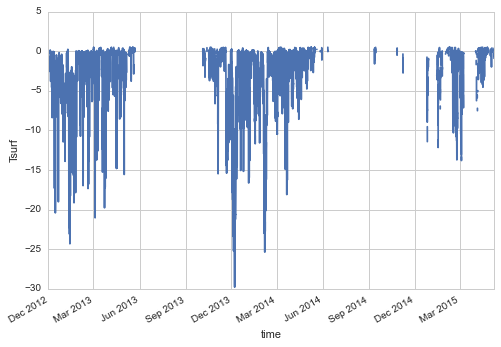

In [6]:
# Time series of raw data
ds.Tsurf.values[ds.Tsurf.values > .5] = np.nan
ds.Tsurf.plot()